# Network Metrics
Includes analysis and visualizations based on degree distributions. Most bipartite networks analyzed in the literature are not directed. That means that each node has a single degree, which is simply the number of links that node has. -

Our $pq$-network is directed. This means that each node had two degrees: in-degree (the number of links going into the node) and out-degree (the number of links going out of the node). So we have four degree distributions: distribution of in-degrees of $p$-nodes, distribution of out-degrees of $p$-nodes; distribution of in-degrees of $q$-nodes; and distribution
of out-degrees of $q$-nodes. The last distribution is trivial since all q-nodes have out-degree equal to 1 (each question is asked by a single person). Thus, we can characterize each $pq$-network by three degree distributions.

In [4]:
import xlrd 
import matplotlib.pyplot as plt
import matplotlib.colorbar
import matplotlib.colors
import matplotlib.cm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chisquare
from math import factorial
from math import exp
from scipy.stats.distributions import chi2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

import os 

from pq_helper import get_dataframe

We will define the following helper functions:

In [2]:
def chi_squared_test(observed, mu, total):
    expected = []
    sum = 0
    for value in range(len(observed) - 1): 
        expected.append(total * (exp(-mu) * mu**value / factorial(value)))
        sum += total * (exp(-mu) * mu**value / factorial(value))
    expected.append(total - sum)
    (testStatistic, pValue) = chisquare(observed, f_exp=expected, 
                                        ddof=len(observed) - 1)  
    # note: the p-value returned by the chisquare function seems to be 
    # incorrect for the test statistic; I verified the return value of chi2.sf 
    # with both online tables of chi-squared value as well as Mathematica and 
    # MATLAB
    p = chi2.sf(testStatistic, len(observed) - 1)
    return (testStatistic, p)

def color_by_nscore(Outdegree, Indegree, NScore):
    df = pd.DataFrame(dict(Outdegree=Outdegree, Indegree=Indegree, 
                           NScore=NScore))     
    cmap = plt.cm.get_cmap('RdYlBu') 
    
    # Normalize to the range of possible values from NScore
    norm = matplotlib.colors.Normalize(vmin=NScore.min(), vmax=NScore.max())
    
    # create a color dictionary  
    colors = {}
    for cval in NScore:
        colors.update({cval : cmap(norm(cval))})
    
    fig = plt.figure(figsize=(20,5))
    #fig = plt.figure(figsize=(200,5)) # use for zoomed view of outdegree 0
    #fig = plt.figure(figsize=(50,5)) # use for zoomed view of outdegree 1        
    m = sns.swarmplot(Outdegree, Indegree, hue=NScore, palette = colors)
    plt.gca().legend_.remove()
    plt.title('In-Degree vs Out-Degree of P-Nodes') 
    
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig.add_axes(ax_cb)
    clb = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm)
    clb.set_label('N-Score')
    plt.show()     
    
def avg_degree(sheet, total):
    Outdegree = sheet['Out-Degree']
    Indegree = sheet['In-Degree']  
    total_out = 0
    total_in = 0
    counter = 0
    
    for i in range(total):
        if sheet['Status'][i] == 1:
            total_out += Outdegree[i]
            counter += 1
        
    for i in range(total):
        if sheet['Status'][i] == 1:
            total_in += Indegree[i]
            
    # average outdegree of status 1 p-nodes
    avg_out = total_out / counter
    
    # average indegree of status 1 p-nodes
    avg_in = total_in / counter 
    
    return (avg_in, avg_out)

First, load in the data:

In [73]:
data_path = 'data/'
path = os.path.join(data_path, 'acm95a100a2018_anonymized_modified.xlsx')
(p_nodes, q_nodes, links, mod_p_nodes) = get_dataframe(path)

In [59]:
p_nodes

,ID,Role,Class,Option,Section,DaysOnline,Views,Contributions,Questions,Notes,Answers,N-Score,Grade,Status,In-Degree,Out-Degree,Seniority
0,P1,Student,U2,ME,5.0,48,60,0,0,0,0,0.531170,B+,0,0,0,U
1,P2,Student,U2,ACM,5.0,150,219,14,0,0,13,0.918357,A+,1,1,5,U
2,P3,Student,U2,ACM,7.0,245,215,9,1,0,4,0.864791,A+,1,4,4,U
3,P4,Student,U3,CS,1.0,107,215,3,0,0,2,0.928847,A+,1,0,3,U
4,P5,Student,U2,ME,3.0,53,216,38,10,0,15,0.944688,A+,1,20,9,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,P192,TA,NaN,NaN,8.0,59,88,1,0,0,0,NaN,NaN,1,0,1,N
192,P193,TA,NaN,NaN,9.0,78,34,0,0,0,0,NaN,NaN,1,0,1,N
193,P194,TA,NaN,NaN,10.0,36,53,3,0,2,1,NaN,NaN,0,0,0,N
194,P195,Head TA,NaN,NaN,NaN,74,237,228,0,7,153,NaN,NaN,1,0,125,N


Observe that we have computed In-Degree and Out-Degree for all $p$-nodes and In-Degree for all $q$-nodes and added these node attributes to `acm95a100a2018_anonymized_modified.xlsx`. We reproduce the code for generating the degrees below:

```{python}
# p-node Out-Degree
p_nodes['Out-Degree'] = [0]*len(p_nodes)

out = links["Start"].value_counts()
nodes = links["Start"].value_counts().index

for node in nodes:
    if node[0] == 'P':
        row_index = int(node[1:]) - 1
        p_nodes.loc[row_index, 'Out-Degree'] = out.loc[node]
     
# p-node and q-node In-Degree
p_nodes['In-Degree'] = [0]*len(p_nodes)
q_nodes['In-Degree'] = [0]*len(q_nodes)

ins = links["End"].value_counts()
nodes = links["End"].value_counts().index
for node in nodes:
    row_index = int(node[1:]) - 1
    if node[0] == 'P':
        p_nodes.loc[row_index, 'In-Degree'] = ins.loc[node]
    else:
        q_nodes.loc[row_index, 'In-Degree'] = ins.loc[node]
```

We extract all unique values of In-Degree and Out-Degree for $p$-nodes in ascending order for later use. Most of our analysis will be done on students only, as instructor and TAs are expected to participate heavily in the network, unlike students.

In [58]:
# list of p-nodes out-degrees (students only)
p_node_out = np.sort(mod_p_nodes['Out-Degree'].value_counts().index)
    
# list of p-nodes in-degrees (students only; note that instructors should 
# all have in-degrees of zero, since they don't ask questions)
p_node_in = np.sort(mod_p_nodes['In-Degree'].value_counts().index) 

Our first network visualization will be a topological visualization that displays all links and nodes on a plane.

We will extract the list of p-nodes with Status $=1$ in the order in which they participated:

In [4]:
status1 = [] # list of status 1 p-nodes
for item in links['Start']:
    if (item[0] == 'P') and (item not in status1):
        status1.append(item)
for item in links['End']:
    if (item[0] == 'P') and (item not in status1):
        status1.append(item)  

We then read in the adjacency matrix constructed from the network links and create a directed bipartite graph from it:

In [9]:
# read in adjacency matrix (which accounts for status 1 nodes only)
book = pd.ExcelFile(os.path.join(data_path, 'adjacency_matrix_with_headers.xlsx'))
df = book.parse()    
    
# create directed graph from adjacency matrix
G = nx.from_numpy_matrix(df.values.transpose(), create_using=nx.DiGraph())

Next, we will relabel the p-nodes with Status $=1$ and the q-nodes so that their numbering starts from 1. This will faciliate our later plots.

In [10]:
new_labels = {}
    
for i in range(96): # relabel p-nodes
    new_labels[i] = status1[i]
for j in range(96, 337): # label q-nodes 
    new_labels[j] = 'Q' + str(j - 95)
        
nx.relabel_nodes(G, new_labels, copy=False)

Now we can set the attributes for our graph:

In [12]:
# set different node shapes for p-nodes and q-nodes
node_shape = {}
for node in G.nodes():
    if node[0] == 'P':
        node_shape[node] = 'o'
    else:
        node_shape[node] = 's'
    
nx.set_node_attributes(G, node_shape, 'shape')   
   
# set different edge colors for links from p- to q-nodes and links from q- to p-nodes
edge_color = {}
for edge in G.edges():
    if edge[0][0] == 'P':
        edge_color[edge] = 'blue'
    else:
        edge_color[edge] = 'red'
    
nx.set_edge_attributes(G, edge_color, 'color') 
    
# adjust k to change how closely nodes are distributed in image
nodePos = nx.layout.spring_layout(G, k=0.3, iterations=20)
nodeShapes = ['o', 's']
edgeColors = ['blue', 'red']

Finally, we draw the graph:

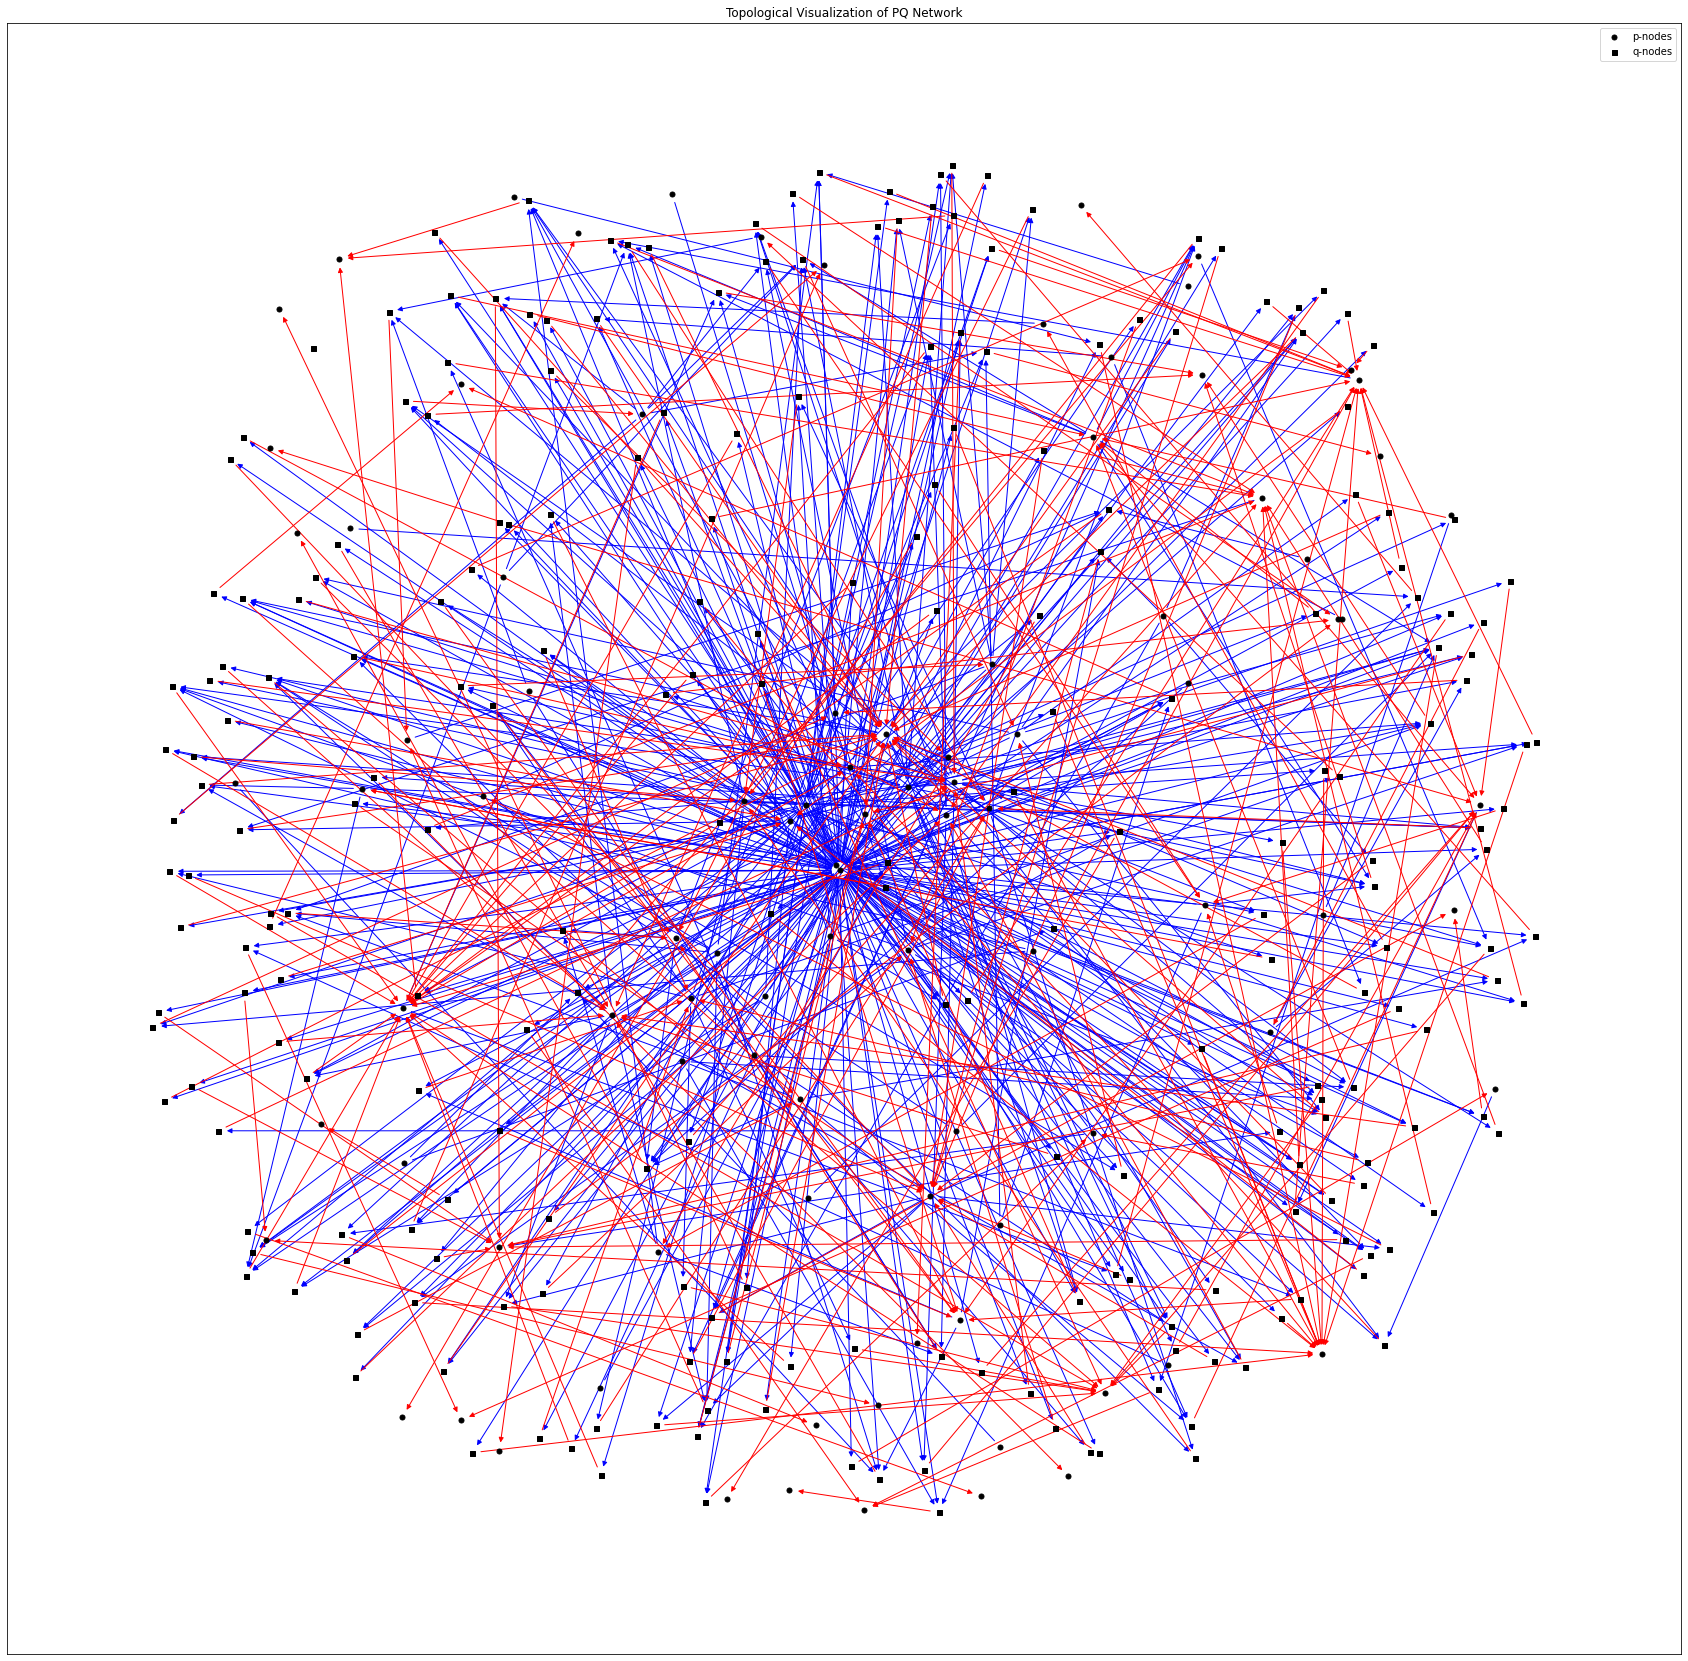

In [15]:
plt.figure(figsize=(30,30))

# draw nodes
for shape in nodeShapes:
    if shape == 'o':
        node_label = 'p-nodes'
    else:
        node_label = 'q-nodes'
    nx.draw_networkx_nodes(G, nodePos, node_shape=shape, 
                            nodelist=[sNode[0] for sNode in filter(lambda x: x[1]['shape']==shape, G.nodes(data = True))], 
                            node_size=25, node_color='black', label=node_label)
    
# draw edges
for color in edgeColors:
    nx.draw_networkx_edges(G, nodePos, edge_color=color, 
                            edgelist=[sEdge for sEdge in filter(lambda x: x[2]['color']==color, G.edges(data = True))])    
    
plt.title('Topological Visualization of PQ Network')
plt.legend()

We can adjust the density of the nodes by changing $k$ above, but it is still difficult to identify useful patterns due to the large number of nodes and connections present. The network is almost completely connected; there is a lone q-node that has no links in the spreadsheet and one other component comprised of 4 nodes. The rest of the graph is connected.

We will next look at a temporal visualization of the network. We have the order (network time) in which nodes and links appeared, and we use this information to create a network where nodes are place along a time line. 

Our general approach is as follows:

We add a new q-node and a new p-node at the network time that a new question is asked, along with the corresponding link between them.

Every time a question is answered, add a new p-node for the person answering and have a link pointing back to the time the question was originally asked (no new q-node). Links from p-nodes to q-nodes will help us visualize how long it took for questions to be answered.

q-nodes will be unique on the timeline but p-nodes may not be (the reason being that if a p-node is unique, then if the person answers any questions following its first appearance in the network, we will lose information about when the question was answered).

Number the p-nodes according to the number of times they have participated (i.e. P1 1, P1 2, etc.)

Colors are added to distinguish between links from q-nodes to p-nodes (red, pointing up) and links from p-nodes to q-nodes (blue, pointing down).

In [18]:
ordered_nodes = []
ordered_edges = []
duplicate_nodes = {} # store number of times a p-node has participated
    
# iterate through all links
for i in range(len(links['ID'])):
    start = links['Start'][i]
    end = links['End'][i]
        
    if start[0] == 'P': # [P answers Q]; always add new p-node but never new q-node
            
        # if p-node has not participated before
        if start not in duplicate_nodes:
            duplicate_nodes[start] = 0
            
        # add new p-node
        count = duplicate_nodes[start]
        duplicate_nodes[start] += 1
        start += '_' + str(count+1) # update start of link
        ordered_nodes.append(start)           
            
    else: # [Q asked by P]; always add new q-node and new p-node 
            
        # add new q-node
        ordered_nodes.append(start)
            
        # if p-node has not participated before
        if end not in duplicate_nodes:
            duplicate_nodes[end] = 0
        
        # add new p-node
        count = duplicate_nodes[end]
        duplicate_nodes[end] += 1            
        end += '_' + str(count+1) # specify end of link
        ordered_nodes.append(end)           
         
    # add edge corresponding to link 
    ordered_edges.append((start, end))   
    
q = 1
p = 2
times = [0] * 910
data = [0] * 910
    
time = 1
for i in range(len(ordered_nodes)):
    if ordered_nodes[i][0] == 'Q': # question is asked
        data[i] = q    # add q-node 
    else: 
        data[i] = p
        # check if p-node follows a q-node (person asks question)
        if ordered_nodes[i-1][0] == 'Q':
            time -= 1 # add p-node at same time as previous q-node
                
    times[i] = time # add node at current timestep
    time += 1

Let's examine the temporal plot:

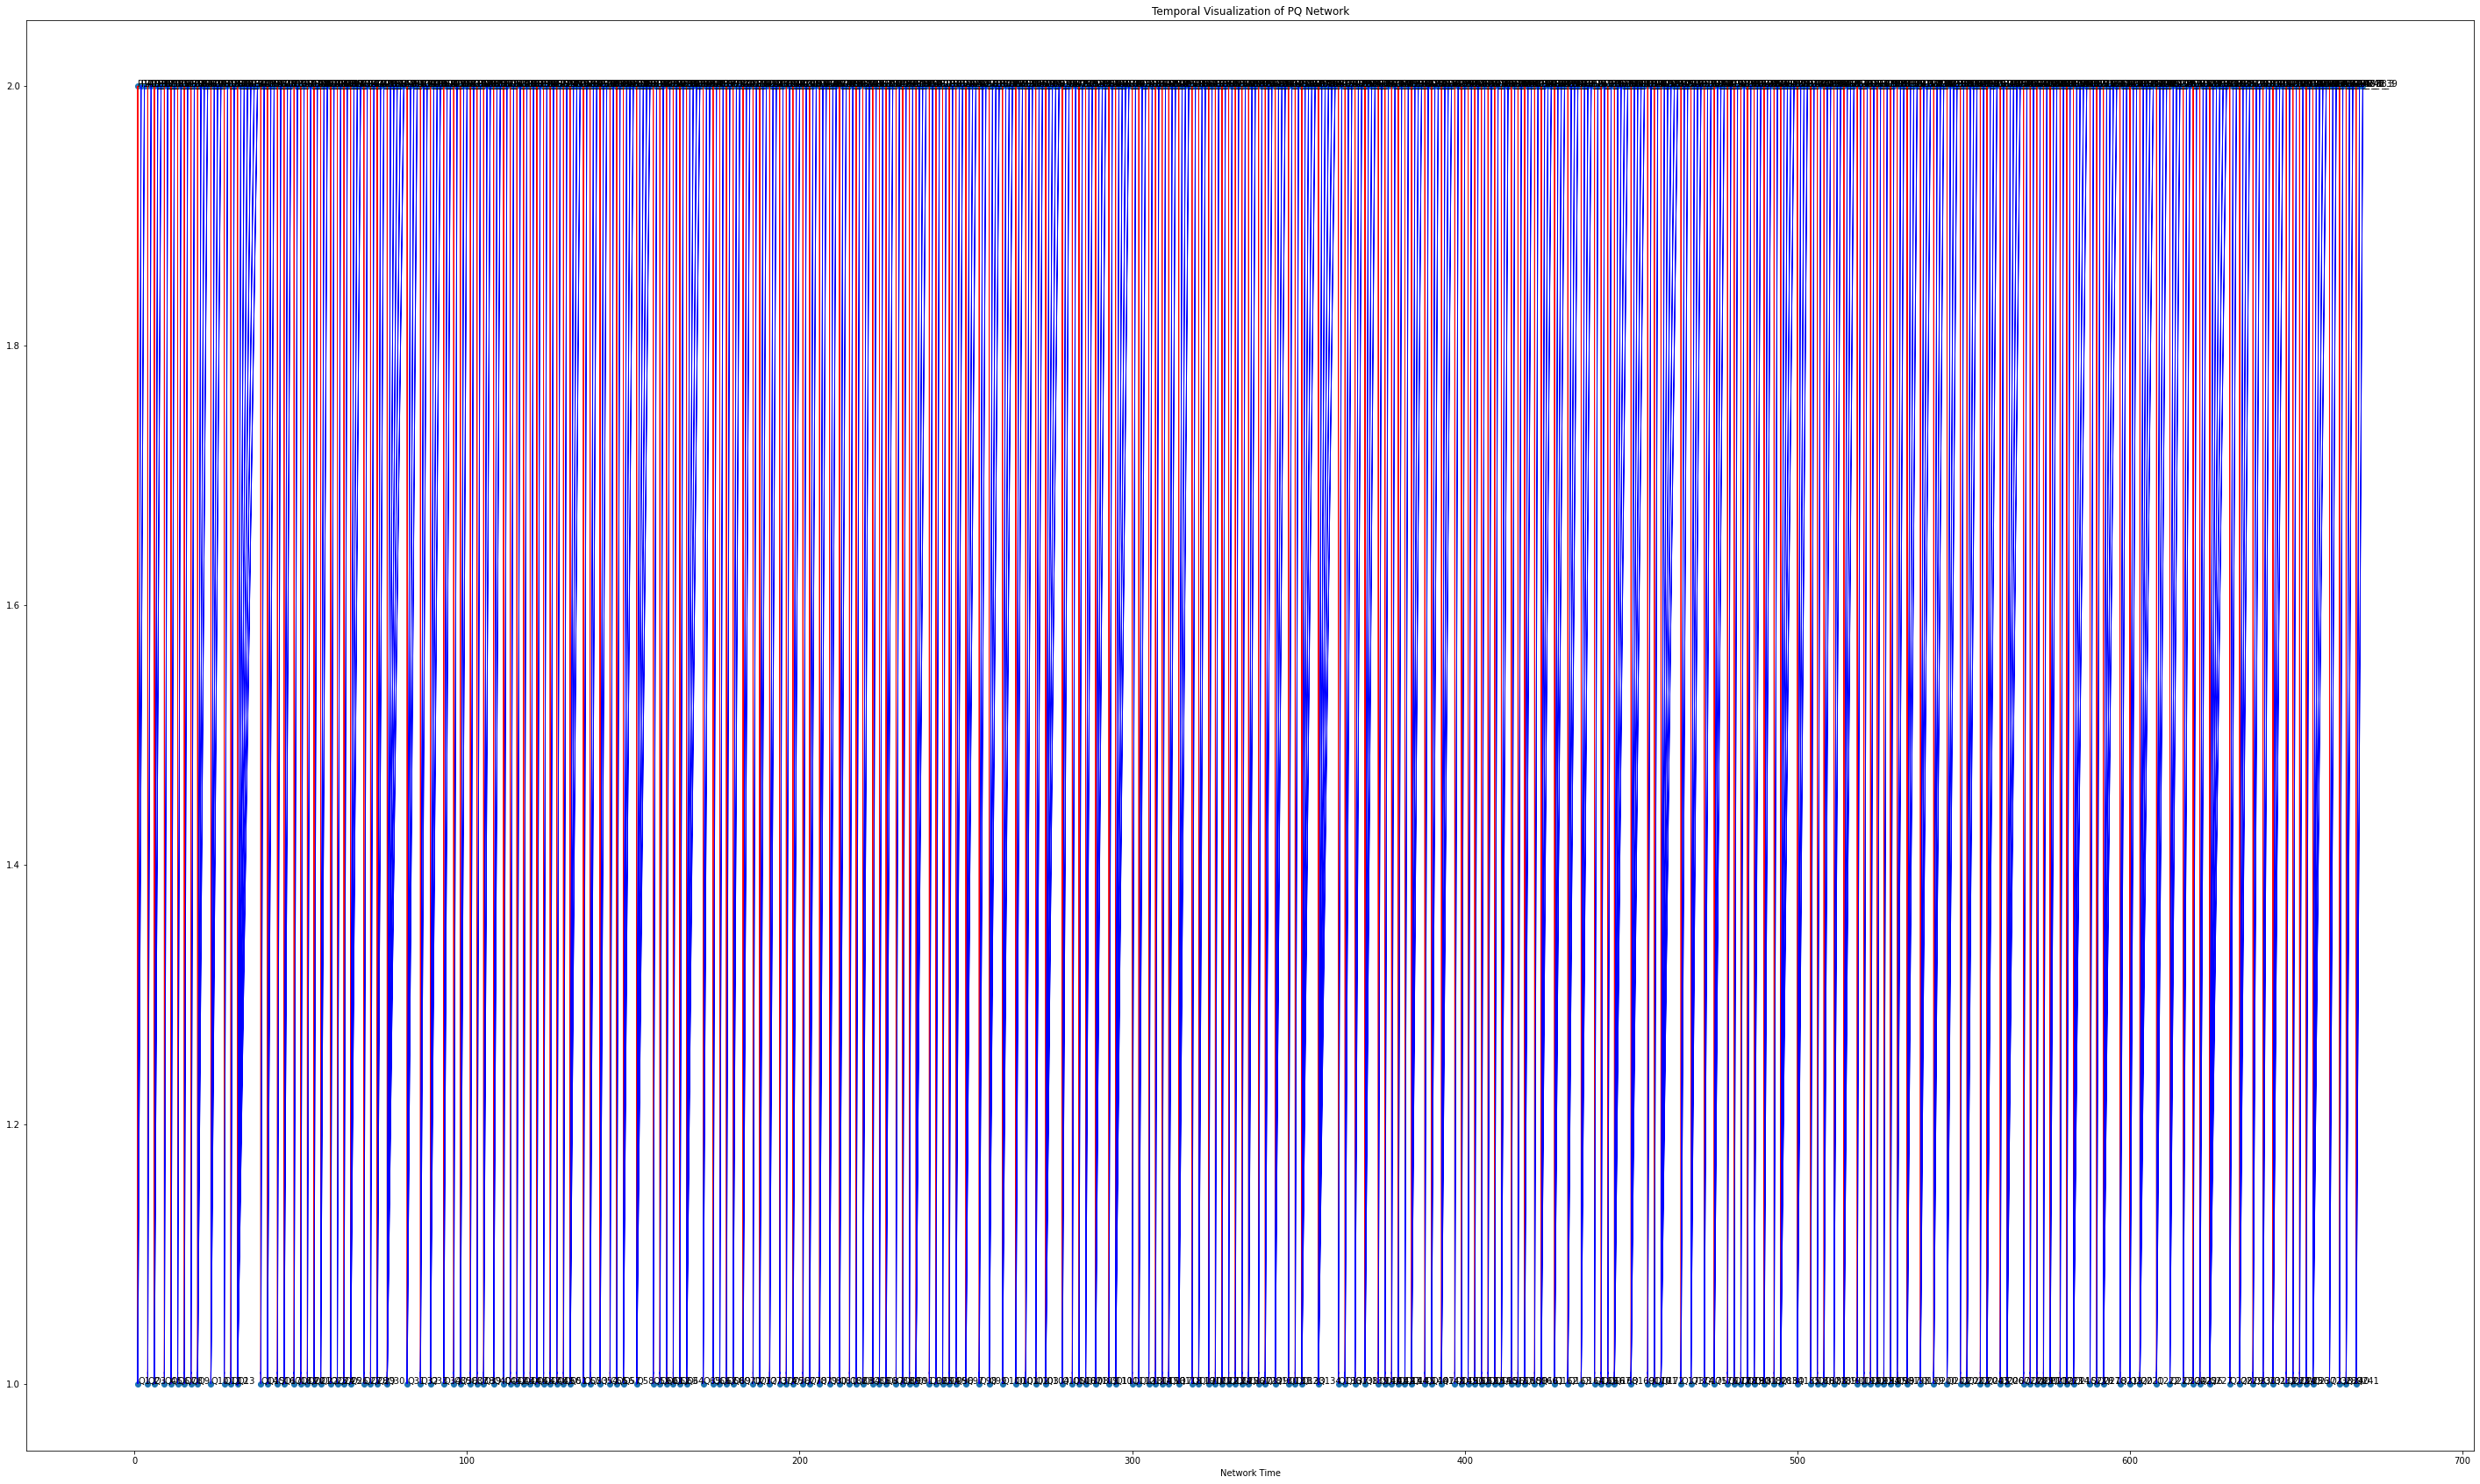

In [22]:
# plot and label nodes
fig, ax = plt.subplots(figsize=(50,30))
ax.scatter(times, data)
for i, txt in enumerate(ordered_nodes):
    ax.annotate(txt, (times[i], data[i]))
    
# plot links
for edge in ordered_edges:
    from_node = edge[0]
    to_node = edge[1]
        
    f = ordered_nodes.index(from_node)
    t = ordered_nodes.index(to_node)
        
    # edges from q-node to p-node are red, from p-node to q-node are blue
    if from_node[0] == 'Q':
        color = 'red'
    else:
        color = 'blue'        
        
    plt.arrow(times[f], data[f], times[t] - times[f], data[t] - data[f], 
                length_includes_head=True, color=color, head_width=0.006, head_length=0.01)
    plt.title('Temporal Visualization of PQ Network')
    plt.xlabel('Network Time')

Zoomed-in versions of the plot above can be found under `/figures/network_visualizations/`.

Based on the temporal visualization and an examination of the data, it appears that the links in our dataset do not encode relative network times between answers. For example, it is reasonable to assume that in real-time, scenarios of the following type occurred: suppose that $q_1$ was asked, then $q_2$ was asked. Next, $q_2$ was answered before $q_1$ was answered. Based on our data, the link representing the answer to $q_1$ appears before the link representing the answer to $q_2$ in network time because $q_1$ appeared first. This leads to formations of the kind pictured above, where p-nodes that answer questions must be answering the most recently asked question and none of the links cross. While this leads to a clean visualization, it also results in the loss of information regarding the actual order in which questions were answered.

### Attributions

Notebook created by Amanda Li. 

Modified from `network_metrics_degree_distributions.py` by Amanda Li.